In [1]:
# Setup display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Base.Iterators: flatten
using Statistics: mean
using Random
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress,save,load, sgd, param, param0,adam, momentum,dropout, relu, Data,gpu,minibatch

In [2]:
import Knet.load
import Knet.save
import AutoGrad

In [111]:
Pkg.status()

    Status `~/.julia/environments/v1.1/Project.toml`
  [944b1d66] CodecZlib v0.5.2
  [5ae59095] Colors v0.9.5
  [5789e2e9] FileIO v1.0.6
  [7073ff75] IJulia v1.18.0
  [6218d12a] ImageMagick v0.7.1
  [916415d5] Images v0.17.3
  [033835bb] JLD2 v0.1.2
  [682c06a0] JSON v0.20.0
  [1902f260] Knet v1.2.1
  [ae8d54c2] Luxor v1.2.0
  [23992714] MAT v0.5.0
  [91a5bcdd] Plots v0.24.0
  [438e738f] PyCall v1.91.1


In [3]:
cd()
cd("Desktop/DeepProject/21.04.19")
X=load("datax2.jld2","a");
Y=load("datay.jld2","b");
Z=load("dataz.jld2","c");
summary(X)

"224×224×3×1440 Array{Float64,4}"

In [5]:
ind=randperm(size(Y,1));
Ynew=Y[ind,1];
Xnew=X[:,:,:,ind];
Znew=Z[:,:,:,ind];
summary(Znew)

"7×7×512×1440 Array{Float32,4}"

In [6]:
Xdtrn=Xnew[:,:,:,1:1296]
Ydtrn=Ynew[1:1296];
Zdtrn=Znew[:,:,:,1:1296]
summary(Xdtrn)

"224×224×3×1296 Array{Float64,4}"

In [8]:
dtrn=minibatch(Xdtrn,Zdtrn,32;xsize=(224,224,3,32),xtype=atype(),ytype=atype())

Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}([0.631373 0.513725 … 0.494118 0.368627; 0.623529 0.505882 … 0.486275 0.360784; … ; 0.47451 0.737255 … 0.603922 0.0823529; 0.462745 0.694118 … 0.603922 0.0784314], Float32[33.3443 0.0 … 0.0 0.0; 19.1474 4.10365 … 5.3014 19.5439; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 32, 1296, false, 1265, 1:1296, false, (224, 224, 3, 32), (7, 7, 512, 1296), KnetArray{Float32,N} where N, KnetArray{Float32,N} where N)

In [9]:
(x,y) = first(dtrn)
println.(summary.((x,y)));

224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [10]:
Xtst=Xnew[:,:,:,1297:1440];
Ytst=Ynew[1297:1440];
Ztst=Znew[:,:,:,1297:1440];

In [11]:
dtst=minibatch(Xtst,Ztst,32;xsize=(224,224,3,32),xtype=atype(),ytype=atype())

Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}([0.25098 0.431373 … 0.796078 0.615686; 0.25098 0.435294 … 0.776471 0.603922; … ; 0.537255 0.376471 … 0.0470588 0.27451; 0.541176 0.4 … 0.0509804 0.270588], Float32[0.0 11.9045 … 0.0 0.0; 0.0 0.0 … 0.0 7.77864; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 32, 144, false, 113, 1:144, false, (224, 224, 3, 32), (7, 7, 512, 144), KnetArray{Float32,N} where N, KnetArray{Float32,N} where N)

In [12]:
(x1,y1) = first(dtst)
println.(summary.((x1,y1)));


224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [13]:
x1

224×224×3×32 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.25098   0.243137  0.235294  …  0.109804  0.113725  0.117647
 0.25098   0.247059  0.239216     0.109804  0.113725  0.117647
 0.254902  0.247059  0.243137     0.109804  0.113725  0.117647
 0.254902  0.247059  0.243137     0.113725  0.113725  0.113725
 0.258824  0.25098   0.243137     0.113725  0.113725  0.113725
 0.25098   0.247059  0.243137  …  0.117647  0.117647  0.117647
 0.247059  0.243137  0.243137     0.121569  0.117647  0.117647
 0.243137  0.243137  0.247059     0.12549   0.121569  0.117647
 0.239216  0.247059  0.25098      0.12549   0.121569  0.117647
 0.243137  0.247059  0.25098      0.12549   0.117647  0.113725
 0.247059  0.247059  0.25098   …  0.121569  0.117647  0.109804
 0.239216  0.243137  0.239216     0.117647  0.113725  0.109804
 0.239216  0.235294  0.231373     0.117647  0.113725  0.109804
 ⋮                             ⋱                              
 0.380392  0.384314  0.388235     0.47451   0.47451   0.470588
 0.40

In [14]:
cd()
cd("Desktop/DeepProject/28.04")
Knet.save("dtst.jld2","m",dtst)
Knet.save("dtrn.jld2","m",dtrn)

In [17]:
cd()
cd("Desktop/DeepProject/minibatches/m1")
dtst=Knet.load("dtstz.jld2","m")
dtrn=Knet.load("dtrnz.jld2","m")

Data{Tuple{KnetArray{Float32,4},KnetArray{Float32,4}}}([0.796078 0.607843 … 0.423529 0.423529; 0.796078 0.596078 … 0.419608 0.415686; … ; 0.482353 0.294118 … 0.698039 0.337255; 0.466667 0.313725 … 0.698039 0.329412], Float32[0.0 0.0 … 1.39198 0.0; 0.834555 0.0 … 30.7991 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 32, 1080, false, 1049, 1:1080, false, (224, 224, 3, 32), (7, 7, 512, 1080), KnetArray{Float32,N} where N, KnetArray{Float32,N} where N)

In [18]:
(x,y) = first(dtrn)
println.(summary.((x,y)));

224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [19]:
(x1,y1) = first(dtst)
println.(summary.((x1,y1)));

224×224×3×32 KnetArray{Float32,4}
7×7×512×32 KnetArray{Float32,4}


In [5]:
function trainresults(file,model; o...)
   # if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst))
           for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,200);lr=1e-3))))
        print("done")
          # print(size(r,1))      
        r = reshape(collect(Float32,flatten(r)),(2,:))
               
          print("done")
       # Knet.gc() # To save gpu memory
    #else
       # isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
       # r = Knet.load(file,"results")
   # end
   # println(minimum(r,dims=2))
   return r
end

trainresults (generic function with 1 method)

In [6]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mean(abs2.(c(x)-y))
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [7]:
# Define a convolutional layer:
struct Conv; w; b; f; p; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv

In [8]:
# Define a convolutional layer:
struct Conv0; w; b; f; p; end
(c::Conv0)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,stride=2))
Conv0(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv0(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv0

In [9]:
# Define a convolutional layer:
struct Conv1; w; b; f; p; end
(c::Conv1)(x) = c.f.(pool(conv4(c.w, dropout(x,c.p);padding=1).+ c.b;window=3,padding=1,stride=2))
Conv1(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0) = Conv1(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop)

Conv1

In [10]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
(d::Dense)(x) = d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [11]:
lenet1 =   Chain(Conv0(3,3,3,64),
                 Conv0(3,3,64,128),
                 Conv0(3,3,128,256),
                Conv0(3,3,256,256),
                Conv1(3,3,256,512))
summary.(l.w for l in lenet1.layers)

5-element Array{String,1}:
 "3×3×3×64 AutoGrad.Param{KnetArray{Float32,4}}"   
 "3×3×64×128 AutoGrad.Param{KnetArray{Float32,4}}" 
 "3×3×128×256 AutoGrad.Param{KnetArray{Float32,4}}"
 "3×3×256×256 AutoGrad.Param{KnetArray{Float32,4}}"
 "3×3×256×512 AutoGrad.Param{KnetArray{Float32,4}}"

In [12]:
lenet1(x1)

7×7×512×32 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0427098  0.0482339  0.0485188  …  0.0452962  0.0412216  0.0351605
 0.0404591  0.0404591  0.0333611     0.0321846  0.0288941  0.0241287
 0.0412148  0.0412148  0.0317854     0.0321846  0.026609   0.026609 
 0.0411772  0.0411772  0.0313131     0.0292621  0.0290532  0.0264662
 0.0381444  0.0381444  0.0290476     0.0292621  0.0290532  0.02368  
 0.0373709  0.0373709  0.0314429  …  0.0303781  0.0309477  0.0269986
 0.0362694  0.0362694  0.0314429     0.0303781  0.0309477  0.0269986

[:, :, 2, 1] =
 0.0327021  0.0287961  0.0285874  0.026573   …  0.0224848  0.0173668
 0.0327021  0.0287961  0.0285874  0.026573      0.0224848  0.0173668
 0.0319885  0.0176839  0.0156597  0.0163131     0.0156755  0.0156755
 0.0319885  0.0176839  0.0153531  0.0163131     0.017279   0.017279 
 0.0312065  0.0171486  0.0121544  0.0121544     0.017279   0.017279 
 0.0303002  0.0133877  0.0112537  0.0108968  …  0.0168315  0.0168315
 0.0394958  0.0345241  0.0345694  0.034

In [13]:
cnn2 = trainresults("cnn2.jld2", lenet1);

1.24e+02  100.00%┣█████████████████████┫ 6600/6600 [12:46/12:46, 8.61i/s]
done

In [14]:
using Plots; default(fmt=:png,ls=:auto)

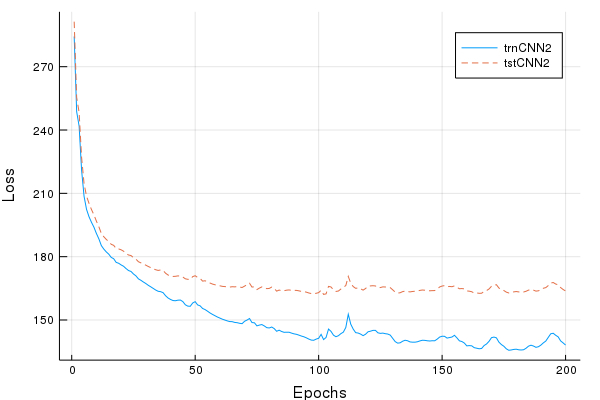

In [15]:
plot([cnn2[1,:], cnn2[2,:]],
     labels=[:trnCNN2 :tstCNN2],xlabel="Epochs",ylabel="Loss")

In [16]:
cd()
cd("Desktop/DeepProject")
Knet.save("lenet1loss.jld2","b",lenet1)